# Hodgkin Huxley Model Analysis

## Description: 

Hodking Huxley model is a ODE model describing excitation of cells through conductance, voltage and current of sodium and potassium, and input and leaking potentials. 

The model is a system of 4 ODEs: 

$$ I = C_m \frac{d}{dt} V_m + g_k n^{4}(V_m - E_K) + g_{Na} m^{3} h (V_m - E_{na}) + g_{l} (V_m - E_l) $$ 

$$ \frac{dn}{dt} = \alpha_{n}(V_m)(1 - n) - \beta_{n}(V_m)n $$

$$ \frac{dm}{dt} = \alpha_{m}(V_m)(1 - m) - \beta_{m}(V_m)m $$

$$ \frac{dh}{dt} = \alpha_{h}(V_m)(1 - h) - \beta_{h}(V_m)m $$


Equations from: http://www.math.pitt.edu/~bdoiron/assets/ermentrout-and-terman-ch-1.pdf

In [3]:
## import modules 
import numpy as np
import scipy as sp
from scipy.integrate import odeint
import matplotlib.pyplot as plt

#### Setting constants

In [4]:
# Membrane capacitance and potential
C_m = 1.0 
V_m = -70.0

# Max sodium conductance and membrane potential
g_Na = 120.0
V_Na = 56.0

# Max potassium conductance and membrane potential
g_K = 36.0
V_K = -77.0 

# Max leak conductance and membrane potential
g_l = 0.3 
V_l = -60

# Time to integrate over
time = np.arange(0.0, 1000.0, 0.1)

# ion variables 
m = 0.05
h = 0.6
n = 0.32

#### Defining model functions

In [1]:
# Input current
def I_inj(time):
    step_current = np.piecewise(time, [(time< 500)*(time>=200), (time< 950)*(time>=700)], [10,50])
    return step_current

# potassium rate functions
def a_n(V_m):
    return 0.01 * (V_m + 55) / (1 - np.exp(-(V_m + 55.0) / 10)) # + 1.E-7)

def B_n(V_m):
    return 0.125 * np.exp(-(V_m + 65.0) / 80)

# sodium rate functions
def a_m(V_m): 
    return 0.1 * (40 + V_m) / (1.0 - np.exp(-(V_m + 40.0) / 10.0)) # + 1.E-7)

def a_h(V_m):
    return 0.07 * np.exp(-(V_m + 65.0) / 20.0)

def B_m(V_m):
    return 4 * np.exp(-(V_m + 65.0) / 18.0)

def B_h(V_m):
    return 1 / (np.exp(-(35 + V_m) / 10) + 1)

def K_current(g_K,n,V_m,V_K):
    return g_K * n**4 * (V_m - V_K)

def Na_current(g_Na, m, h, V_m, V_Na):
    return g_Na * m**3 * h * (V_m - V_Na)
    
def leak_current(g_l, V_m, V_l):
    return g_l * (V_m - V_l)

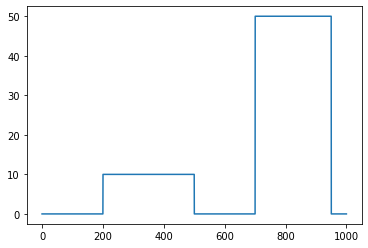

In [6]:
inj = I_inj(time)
plt.plot(time, inj)

##### Setting up model system

In [100]:
def hh_model(y, t, parameters):
    '''Takes in y dynamics variables, V_m, n, m and h. Array of time steps to integrate over. 
    List of constant parameters, reversal potentials and conductances 

    Returns values for derivatives w.r.t time for Voltage and ion rate coefficience n, m and h. 
    '''
    V_m, n, m, h = y
    g_K, V_K, g_Na, V_Na, g_l, C_m = parameters
    
    # Total current through the membrane    
    dVdt = I_inj(t) - K_current(g_K,n,V_m,V_K) - Na_current(g_Na, m, h, V_m, V_Na) - leak_current(g_l, V_m, V_l) / C_m
 
    # Derivative of n, potassium channel activation, w.r.t. time
    dndt = a_n(V_m) * (1 - n) - B_n(V_m) * n

    # Derivative of m, sodium channel activion, w.r.t. time
    dmdt = a_m(V_m) * (1 - m) - B_m(V_m) * m

    # Derivative of h, sodium channel in-activion, w.r.t. time

    dhdt = a_h(V_m) * (1 - h) - B_h(V_m) * h
    
    return [dVdt, dndt, dmdt, dhdt] 

In [101]:
y0 = [V_m, n, m, h]
parameters = [g_K, V_K, g_Na, V_Na, g_l, C_m]

X = hh_model(y0, time, parameters)

In [102]:
sol = odeint(hh_model,y0, time, args=(parameters,))

In [103]:
Voltage = sol[:,0]
iK = K_current(g_K,n = sol[:,1],V_m = sol[:,0],V_K = V_K)
iNa = Na_current(g_Na, m = sol[:,2], h = sol[:,3], V_m = sol[:,0], V_Na = V_Na)
il = leak_current(g_l, V_m = sol[:,3], V_l = V_l)

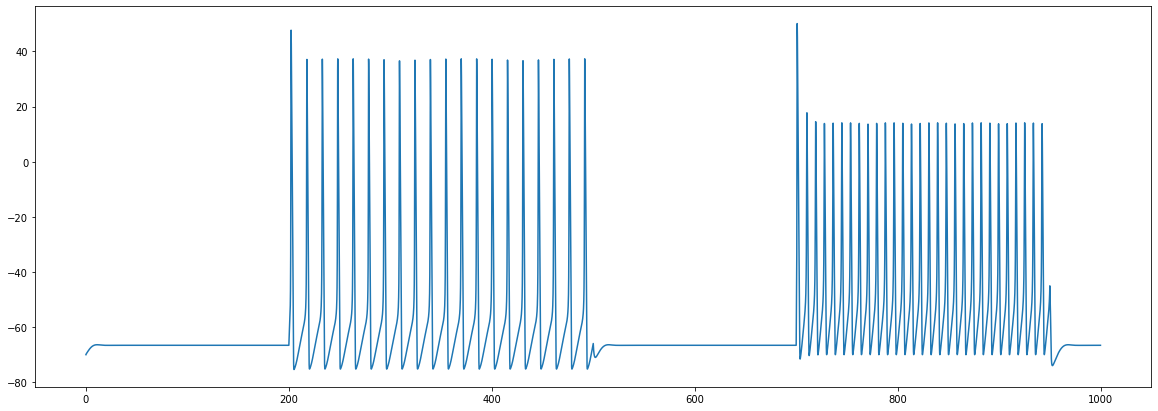

In [104]:
plt.plot(time,Voltage)
plt.rcParams["figure.figsize"] = (20,7)
plt.show()

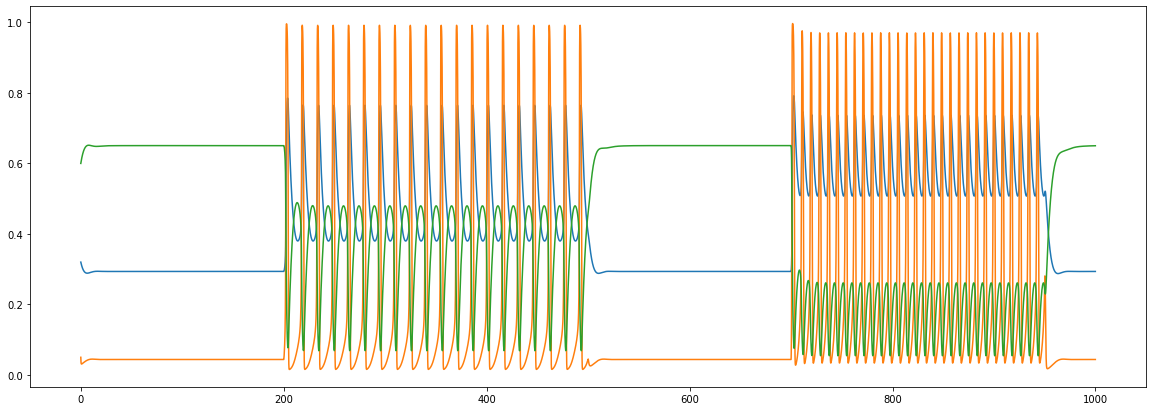

In [105]:
plt.plot(time,sol[:,1])
plt.plot(time,sol[:,2])
plt.plot(time,sol[:,3])
plt.rcParams["figure.figsize"] = (20,7)
plt.show()

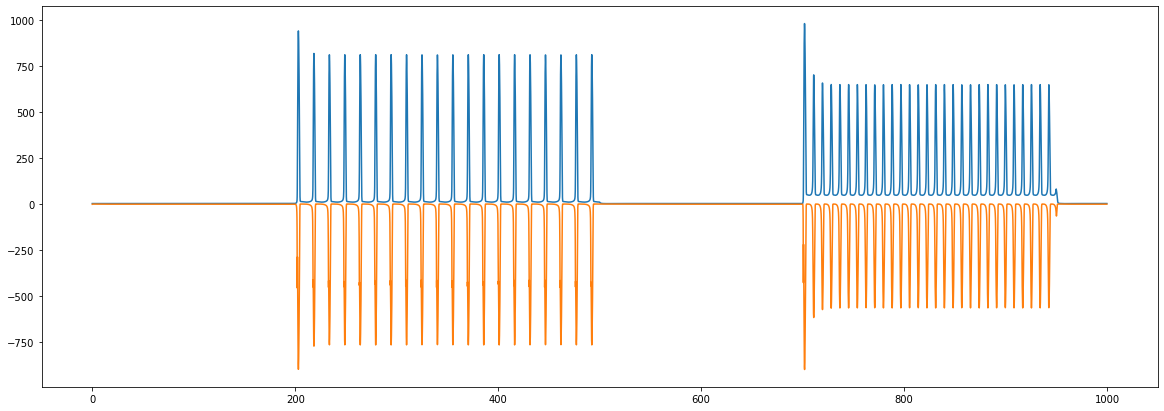

In [106]:
plt.plot(time,iK)
plt.plot(time,iNa)
plt.rcParams["figure.figsize"] = (20,7)
plt.show()

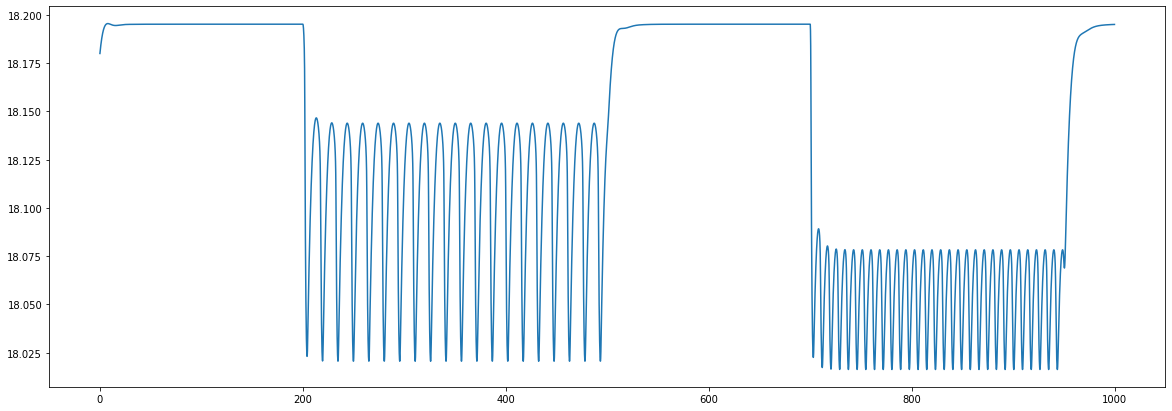

In [107]:
plt.plot(time,il)
plt.rcParams['figure.figsize'] = (20,7)
plt.show()

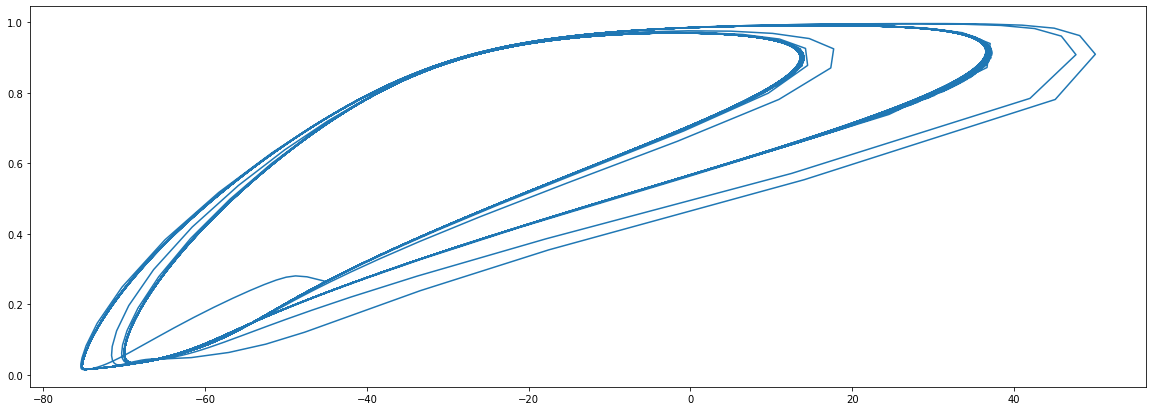

In [108]:
plt.plot(sol[:,0],sol[:,2])



In [ ]:
ymax = plt.ylim(ymin=0)[1]                        # get axis limits
xmax = plt.xlim(xmin=0)[1]

nb_points   = 20
x = np.linspace(0, xmax, nb_points)
y = np.linspace(0, ymax, nb_points)
x_t = np.linspace(0, 500, nb_points)
y_t = np.linspace(0, 500, nb_points)
X1 , Y1  = np.meshgrid(x, y)                       # create a grid

#DX1, DY1 = dndt(X1), dmdt(Y1)                 # compute growth rate on the gridt
M = (np.hypot(DX1, DY1))                           # Norm of the growth rate 
DX1 /= M                                        # Normalize each arrows
DY1 /= M

Q = plt.quiver(X1, Y1, X1, Y1, M, pivot='mid', cmap=plt.cm.jet)